## Generative Latent Replay

Experimental code to test generative latent replay on benchmark continual learning problems.

i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [37]:
# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms as T
from avalanche.training import Naive, Replay, plugins
from avalanche.benchmarks.classic import RotatedMNIST, PermutedMNIST

# Local imports
from src import utils, plotting, models
from src.strategies import LatentReplay, GenerativeLatentReplay


Setup

In [38]:
# Reproducibility
SEED = 731
utils.set_seed(SEED)

Problem definition

In [39]:
# Dataset specific attributes
n_experiences = 5
transform = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])

experiences = PermutedMNIST(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
        # rotations_list=[0, 60, 300],
    )

In [41]:
import importlib
importlib.reload(utils)

experiences = utils.shrink_dataset(experiences, 1000)

Hyperparameters

In [42]:
# Replays
replay_buffer_size = 600

# Frozen backbone
freeze_depth = 1
latent_layer_number = freeze_depth * 3

# Generic hyperparams
lr = 0.1  # 0.001
l2 = 0.0005
momentum = 0.9

eval_rate = 1

strategy_kwargs = {
    "train_epochs": 40,
    "train_mb_size": 128,
    "eval_mb_size": 512,
    "device": utils.get_device(),
    "plugins": [
        plugins.EarlyStoppingPlugin(
            patience=eval_rate, val_stream_name="train_stream/Task000", margin=0.005, #metric
        )
    ],
    "eval_every": eval_rate,
}


Building base model

In [43]:
# Model specification
model = "mlp"

model_kwargs = {
    "drop_rate": 0,
    "num_classes": 10,
    "hidden_size": 100,
    "hidden_layers": 2,
}

In [44]:
# Model
n_models = 6

if model == "mlp":
    networks = [models.SimpleMLP(**model_kwargs) for i in range(n_models)]
    transform = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])

elif model == "cnn":
    networks = [models.SimpleCNN(**model_kwargs) for i in range(n_models)]
    transform = T.Compose([T.ToTensor()])

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Building Continual Learning methods for comparison

In [45]:
# Baseline
naive_strategy = Naive(
    model=networks[0],
    optimizer=SGD(networks[0].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    eval_plugin=utils.get_eval_plugin('naive'),
    **strategy_kwargs,
)

# Benchmark - raw and latent replay
replay_strategy = Replay(
    model=networks[1],
    criterion=CrossEntropyLoss(),
    optimizer=SGD(networks[1].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    eval_plugin=utils.get_eval_plugin('replay'),
    **strategy_kwargs,
)

# Sanity check - should perform similar to "Replay"
replay_thawed_strategy = LatentReplay(
   model=networks[2],
   latent_layer_num=0,
   subsample_replays=True,
   rm_sz=replay_buffer_size,
   eval_plugin=utils.get_eval_plugin('replay_reimplemented'),
   **strategy_kwargs,
)

lat_replay_strategy = LatentReplay(
    model=networks[3],
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    subsample_replays=True,
    eval_plugin=utils.get_eval_plugin('latent_replay'),
    **strategy_kwargs,
)

gen_replay_strategy = GenerativeLatentReplay(
    model=networks[4],
    rm_sz=replay_buffer_size,
    latent_layer_num=0,
    eval_plugin=utils.get_eval_plugin('generative_replay'),
    **strategy_kwargs,
)

# Continual learning strategy
gen_lat_replay_strategy = GenerativeLatentReplay(
    model=networks[5],
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    eval_plugin=utils.get_eval_plugin('generative_latent_replay'),
    **strategy_kwargs,
)

# print(gen_lat_replay_strategy.model)

In [46]:
strategies = {
    "Generative Latent Replay": {"model": gen_lat_replay_strategy, "results": []},
    #"Latent Replay": {"model": lat_replay_strategy, "results": []},
    #"Replay": {"model": replay_strategy, "results": []},
    #"Naive": {"model": naive_strategy, "results": []},
    #"Replay (re-imp)": {"model": replay_thawed_strategy, "results": []},
    #"Generative Replay": {"model": gen_replay_strategy, "results": []},
}

Training loop

In [47]:
for strat in strategies.values():
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        strat["model"].train(train_exp)

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 0...


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 1...
Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 2...
Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 3...
Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 4...
Generator trained.


Plotting

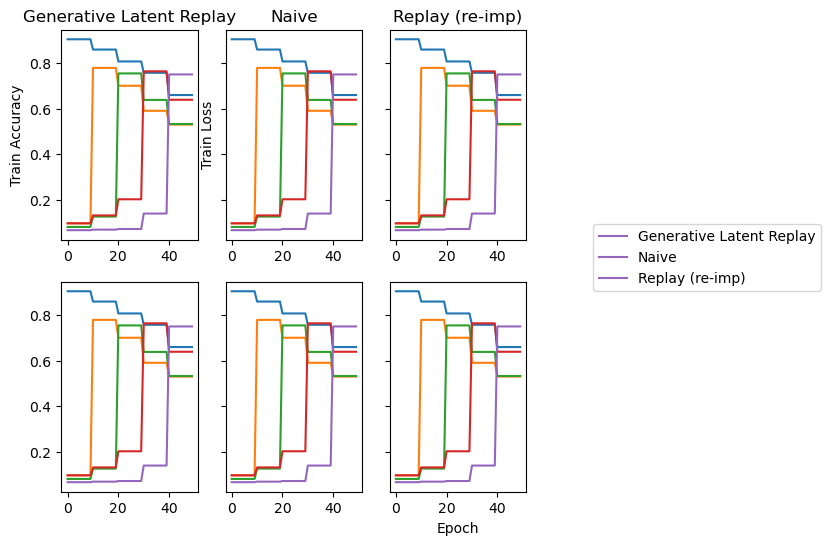

In [61]:
import importlib
importlib.reload(plotting)

for key in strategies_cache.keys():
    if key not in strategies.keys():
        strategies[key] = strategies_cache[key]

results = [s["results"] for s in strategies.values()]
plotting.plot_multiple_results(results, strategies.keys(), n_experiences, loss=True)


In [35]:
strategies_cache = strategies

In [30]:
utils.results_to_df(strategies.keys(), results)

IndexError: list index out of range

In [31]:
print(results)

[[{'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000': 0.9764, 'Loss_Exp/eval_phase/train_stream/Task000/Exp000': 0.07849345082441966, 'Top1_Acc_Stream/eval_phase/train_stream/Task000': 0.6223733333333333, 'Loss_Stream/eval_phase/train_stream/Task000': 1.5755851154756546, 'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.983156890617986, 'Loss_Epoch/train_phase/train_stream/Task000': 0.057067659045340356, 'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp001': 0.5909833333333333, 'Loss_Exp/eval_phase/train_stream/Task000/Exp001': 1.6398248795191448, 'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp002': 0.4979166666666667, 'Loss_Exp/eval_phase/train_stream/Task000/Exp002': 2.128642352231344, 'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp003': 0.5063, 'Loss_Exp/eval_phase/train_stream/Task000/Exp003': 2.23494083925883, 'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp004': 0.5402666666666667, 'Loss_Exp/eval_phase/train_stream/Task000/Exp004': 1.7960240555445353}, {'Top1_Acc_Exp/